<a href="https://colab.research.google.com/github/Has970211/Corrosion-Detection/blob/main/UNET_for_CD___.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repo. Loading

In [ ]:
!git clone https://github.com/Has970211/Corrosion-Detection

Cloning into 'Corrosion-Detection'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 556 (delta 3), reused 0 (delta 0), pack-reused 517
Receiving objects: 100% (556/556), 138.60 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [ ]:
cd Corrosion-Detection/dataset

/content/Corrosion-Detection/dataset


# Import libraries

In [ ]:
import numpy as np 
import glob
from PIL import Image
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import imageio
import albumentations as albu
import os
from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

In [ ]:
import torchvision.transforms.functional as TF
import random

# Dataset generation

### Alpha channel separation 

In [ ]:
def alpha_channel(mask_path):
      img=Image.open(mask_path, 'r')
      alpha1=img.split()[-1]
      #alpha_array=np.array(alpha1)
      #gt_ = np.zeros(alpha_array.shape)
      #gt_[ alpha_array[:,:] > 127] = 1
      #im=Image.fromarray(gt_)
      
      return alpha1

def Totensor(img):
  ary = np.array(img)
  gt_ = np.zeros(ary.shape)
  gt_[ ary[:,:] > 127] = 1
  mask=torch.from_numpy(gt_)
  return mask

## DataLoaders

In [ ]:
class DataLoaderSegmentation(data.Dataset):

    def __init__(self, folder_path, file_path_img, file_path_mask):
        super(DataLoaderSegmentation, self).__init__()

        #self.transform = transform
        self.img_files = glob.glob(os.path.join(folder_path,file_path_img,'*.png'))
        print(self.img_files)
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,file_path_mask,os.path.basename(img_path)))
        print(self.mask_files)

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(600, 600))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(572, 572))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = Totensor(mask)
        return image, mask

    def __getitem__(self, index):
        #index = index // len(self.img_files)
        #index = index 
        image = Image.open(self.img_files[index]).convert('RGB')
        mask = alpha_channel(self.mask_files[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
      return len(self.img_files)
    

In [ ]:
class DataLoaderSegmentationVal(data.Dataset):

    def __init__(self, folder_path, file_path_img, file_path_mask):
        super(DataLoaderSegmentationVal, self).__init__()

        #self.transform = transform
        self.img_files = glob.glob(os.path.join(folder_path,file_path_img,'*.png'))
        print(self.img_files)
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,file_path_mask,os.path.basename(img_path)))
        print(self.mask_files)

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(600, 600))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(572, 572))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = Totensor(mask)
        return image, mask

    def __getitem__(self, index):
        #index = index // len(self.img_files)
        #index = index 
        image = Image.open(self.img_files[index]).convert('RGB')
        mask = alpha_channel(self.mask_files[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
      return len(self.img_files)
    

In [ ]:
train_dataset=DataLoaderSegmentation(folder_path="",file_path_img='image', file_path_mask='mask')
train_dataloader=data.DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
print(len(train_dataloader))

val_dataset=DataLoaderSegmentationVal(folder_path="",file_path_img='image_v', file_path_mask='mask_v')
val_dataloader=data.DataLoader(val_dataset, batch_size=4, shuffle=False)
print(len(val_dataloader))

['image/13.png', 'image/L43.png', 'image/6.png', 'image/L70.png', 'image/L9.png', 'image/14.png', 'image/10.png', 'image/2.png', 'image/11.png', 'image/4.png', 'image/8.png', 'image/L64.png', 'image/5.png', 'image/L74.png', 'image/L57.png', 'image/L46.png', 'image/L44.png', 'image/L56.png', 'image/L67.png', 'image/9.png', 'image/20.png', 'image/1.png', 'image/L19.png', 'image/12.png', 'image/7.png', 'image/L45.png', 'image/L66.png']
['mask/13.png', 'mask/L43.png', 'mask/6.png', 'mask/L70.png', 'mask/L9.png', 'mask/14.png', 'mask/10.png', 'mask/2.png', 'mask/11.png', 'mask/4.png', 'mask/8.png', 'mask/L64.png', 'mask/5.png', 'mask/L74.png', 'mask/L57.png', 'mask/L46.png', 'mask/L44.png', 'mask/L56.png', 'mask/L67.png', 'mask/9.png', 'mask/20.png', 'mask/1.png', 'mask/L19.png', 'mask/12.png', 'mask/7.png', 'mask/L45.png', 'mask/L66.png']
6
['image_v/L69.png', 'image_v/L76.png', 'image_v/20.png', 'image_v/16.png', 'image_v/L71.png', 'image_v/18.png']
['mask_v/L69.png', 'mask_v/L76.png', 'm

In [ ]:
for i, (inputs, labels) in enumerate(val_dataloader):
  print(inputs.size(), labels.size())
  if i > 10:
    break

torch.Size([4, 3, 572, 572]) torch.Size([4, 572, 572])
torch.Size([2, 3, 572, 572]) torch.Size([2, 572, 572])


# **Unet Model**

### **Unet Model Architecture**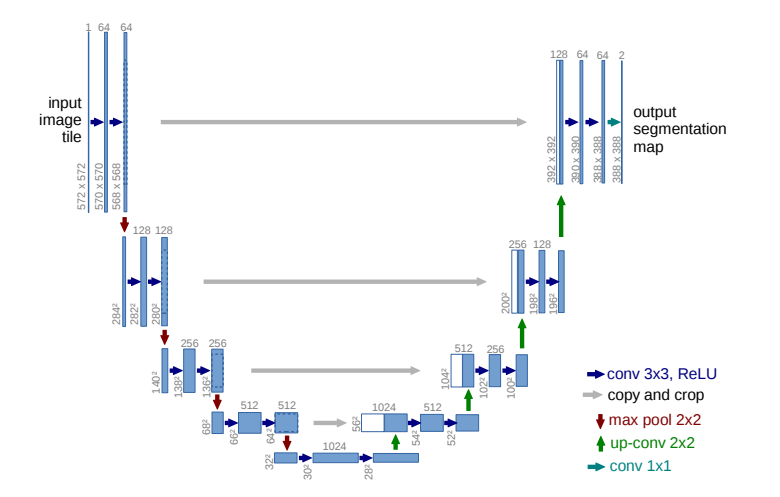

In [ ]:
class Unet_original(nn.Module):
  def __init__(self):
    super(Unet_original, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.conv11 = nn.Conv2d(64, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv11.weight)

    self.pool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(64, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv2.weight)
    self.conv22 = nn.Conv2d(128, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv22.weight)

    self.conv3 = nn.Conv2d(128, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv3.weight)
    self.conv33 = nn.Conv2d(256, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv33.weight)

    self.conv4 = nn.Conv2d(256, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv4.weight)
    self.conv44 = nn.Conv2d(512, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv44.weight)

    self.drop1 = nn.Dropout(p=0.5)

    self.conv5 = nn.Conv2d(512, 1024, 3, padding=0)
    nn.init.kaiming_normal_(self.conv5.weight)
    self.conv55 = nn.Conv2d(1024, 1024, 3, padding=0)
    nn.init.kaiming_normal_(self.conv55.weight)

    self.up1 = nn.Upsample(scale_factor=2)

    self.uconv6 = nn.Conv2d(1024, 512, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv6.weight)

    self.conv6 = nn.Conv2d(1024, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv6.weight)
    self.conv66 = nn.Conv2d(512, 512, 3, padding=0)
    nn.init.kaiming_normal_(self.conv66.weight)

    self.uconv7 = nn.Conv2d(512, 256, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv7.weight)

    self.conv7 = nn.Conv2d(512, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv7.weight)
    self.conv77 = nn.Conv2d(256, 256, 3, padding=0)
    nn.init.kaiming_normal_(self.conv77.weight)

    self.uconv8 = nn.Conv2d(256, 128, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv8.weight)

    self.conv8 = nn.Conv2d(256, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv8.weight)
    self.conv88 = nn.Conv2d(128, 128, 3, padding=0)
    nn.init.kaiming_normal_(self.conv88.weight)

    self.uconv9 = nn.Conv2d(128, 64, 2, padding=(1,1), dilation=2)
    nn.init.kaiming_normal_(self.uconv6.weight)

    self.conv9 = nn.Conv2d(128, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv9.weight)
    self.conv99 = nn.Conv2d(64, 64, 3, padding=0)
    nn.init.kaiming_normal_(self.conv99.weight)

    self.conv10 = nn.Conv2d(64, 2, 1)
    nn.init.kaiming_normal_(self.conv10.weight)
    #self.conv1010 = nn.Conv2d(2, 1, 1)
    #nn.init.kaiming_normal_(self.conv1010.weight)    


  def forward(self, x):
    x1 = F.relu(self.conv1(x))
    x1 = F.relu(self.conv11(x1))
    p1 = self.pool1(x1)
    x2 = F.relu(self.conv2(p1))
    x2 = F.relu(self.conv22(x2))
    p2 = self.pool1(x2)
    x3 = F.relu(self.conv3(p2))
    x3 = F.relu(self.conv33(x3))
    p3 = self.pool1(x3)
    x4 = F.relu(self.conv4(p3))
    d4 = self.drop1(F.relu(self.conv44(x4)))
    x5 = self.pool1(d4)
    x5 = F.relu(self.conv5(x5))
    x5 = self.drop1(F.relu(self.conv55(x5)))

    #up
    u66 = self.up1(x5)
    u6 = F.relu(self.uconv6(u66))
    d4c = d4[:,:,4:-4,4:-4]
    #return x1.size(), p1.size(), x2.size(), p2.size(), x3.size(), p3.size(), x4.size(), d4.size(), x5.size(), u66.size(), u6.size()
    m6 = torch.cat((d4c, u6), 1)
    #return x1.size(), p1.size(), x2.size(), p2.size(), x3.size(), p3.size(), x4.size(), d4.size(), x5.size(), u66.size(), u6.size(), m6.size()
    m6 = F.relu(self.conv66(F.relu(self.conv6(m6))))

    u7 = F.relu(self.uconv7(self.up1(m6)))
    x3c = x3[:,:,16:-16,16:-16]
    m7 = torch.cat((x3c, u7), 1)
    m7 = F.relu(self.conv77(F.relu(self.conv7(m7))))

    u8 = F.relu(self.uconv8(self.up1(m7)))
    x2c = x2[:,:,40:-40,40:-40]
    m8 = torch.cat((x2c, u8), 1)
    m8 = F.relu(self.conv88(F.relu(self.conv8(m8))))

    u9 = F.relu(self.uconv9(self.up1(m8)))
    x1c = x1[:,:,88:-88,88:-88]
    m9 = torch.cat((x1c, u9), 1)
    m9 = F.relu(self.conv99(F.relu(self.conv9(m9))))

    x9=self.conv10(m9)
    #x9 = self.conv1010(F.relu(self.conv10(m9)))
    
    return x9

# **Training**

## Evaluator

In [ ]:
class Evaluator(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.confusion_matrix = np.zeros((self.num_classes,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_classes)
        label = self.num_classes * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_classes**2)
        confusion_matrix = count.reshape(self.num_classes, self.num_classes)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes,) * 2)

In [ ]:
evaluator = Evaluator(num_classes = 2)

In [ ]:
model = Unet_original()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

#loss_fn = CrossEntropy2d()
loss_fn=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) #optimizer function

In [ ]:
epoch = 0
num_epochs = 25

## Training loop

In [ ]:
for epoch in range(num_epochs):
    print("Starting Epoch",epoch)

    train_loss = 0
    
    model.train() 
    for inputs, labels in tqdm(train_dataloader):
        
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        #inputs.unsqueeze_(1)
        #labels.squeeze_(1)
        labels = F.pad(labels,(-92,-92,-92,-92))

        # print(inputs.shape, labels.shape)

        optimizer.zero_grad() # Clear optimizers
        
        output = model.forward(inputs) # Forward pass
        loss = loss_fn(output, labels) #
        
        loss.backward() # Calculate gradients (backpropogation)
        
        optimizer.step() # Adjust parameters based on gradients
        
        train_loss += loss.item()*inputs.size(0) # Add the loss to the training set's rnning loss

        # Add batch sample into evaluator
        target = labels.cpu().numpy()
        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred )

        
    # Metrics
    train_loss = train_loss / len(train_dataloader.dataset)
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    print("Training Acc: {} \t Acc_class: {}\t mIoU: {}\t fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    
    
    val_loss=0
    model.eval() #Enter eval mode
    with torch.no_grad(): # Tell torch not to calculate gradients
      for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long) # Move to device #, dtype=torch.long
        labels = F.pad(labels,(-92,-92,-92,-92))
        output = model.forward(inputs) # Forward pass
        valloss = loss_fn(output, labels) # Calculate Loss
        val_loss += valloss.item()*inputs.size(0) # Add loss to the validation set's running loss
              
        target = labels.cpu().numpy()
        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred)
            
      
            
    
    # Get the average loss for the entire epoch
    
    valid_loss = val_loss / len(val_dataloader.dataset)
    # Print out the information
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, valid_loss))
    print("Validation Acc: {} \t Acc_class: {}\t mIoU: {}\t fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    

    
    
    print("\n")

    epoch+=1

    #torch.Size([4, 1, 572, 572]) torch.Size([4, 2, 388, 388]) torch.Size([4, 388, 388]) --> output from previous model

Starting Epoch 0



Epoch: 0 	Training Loss: 0.738916
Training Acc: 0.6779216818117405 	 Acc_class: 0.4742812615463748	 mIoU: 0.3722538484039547	 fwIoU: 0.5461392121710289



Epoch: 0 	Validation Loss: 0.468938
Validation Acc: 0.683051688100046 	 Acc_class: 0.4737798773651546	 mIoU: 0.36915771260711455	 fwIoU: 0.5380071174663702


Starting Epoch 1



Epoch: 1 	Training Loss: 0.309865
Training Acc: 0.7463067276012328 	 Acc_class: 0.5319917787766062	 mIoU: 0.4255628508006429	 fwIoU: 0.598757006993556



Epoch: 1 	Validation Loss: 0.432911
Validation Acc: 0.7454714236369433 	 Acc_class: 0.5340859639352439	 mIoU: 0.42545466354733175	 fwIoU: 0.593491128818529


Starting Epoch 2



Epoch: 2 	Training Loss: 0.281612
Training Acc: 0.7752249461002384 	 Acc_class: 0.5756572677628596	 mIoU: 0.46936175691877663	 fwIoU: 0.6295401201353708



Epoch: 2 	Validation Loss: 0.368050
Validation Acc: 0.7760150594584382 	 Acc_class: 0.5812100000968681	 mIoU: 0.47392114581606004	 fwIoU: 0.6288265368092485


Starting Epoch 3



Epoch: 3 	Training Loss: 0.239877
Training Acc: 0.7989353931379624 	 Acc_class: 0.623804273747982	 mIoU: 0.5196557466990852	 fwIoU: 0.6615611336479803



Epoch: 3 	Validation Loss: 0.361959
Validation Acc: 0.7987604399156836 	 Acc_class: 0.6254886277569198	 mIoU: 0.5210456487559865	 fwIoU: 0.6602126536334254


Starting Epoch 4



Epoch: 4 	Training Loss: 0.186823
Training Acc: 0.8191948865447976 	 Acc_class: 0.6669351175754454	 mIoU: 0.56580894630458	 fwIoU: 0.6911826598816244



Epoch: 4 	Validation Loss: 0.356116
Validation Acc: 0.8185257466255713 	 Acc_class: 0.667014212035432	 mIoU: 0.5658170958436948	 fwIoU: 0.6894177827540765


Starting Epoch 5



Epoch: 5 	Training Loss: 0.161082
Training Acc: 0.8334705368911888 	 Acc_class: 0.6976287406881501	 mIoU: 0.5990985058544214	 fwIoU: 0.7128740488496352



Epoch: 5 	Validation Loss: 0.438281
Validation Acc: 0.8318551756001936 	 Acc_class: 0.6948827850926804	 mIoU: 0.5962895000125652	 fwIoU: 0.7098026048169945


Starting Epoch 6



Epoch: 6 	Training Loss: 0.203010
Training Acc: 0.8399041111555686 	 Acc_class: 0.7104250767636829	 mIoU: 0.6137581585797242	 fwIoU: 0.7222321589240467



Epoch: 6 	Validation Loss: 0.328509
Validation Acc: 0.8390851717453907 	 Acc_class: 0.7095280445514771	 mIoU: 0.6128990960186822	 fwIoU: 0.7205070146973537


Starting Epoch 7



Epoch: 7 	Training Loss: 0.169476
Training Acc: 0.8468703360030813 	 Acc_class: 0.7207064575710682	 mIoU: 0.6270421283493135	 fwIoU: 0.7321190002950483



Epoch: 7 	Validation Loss: 0.156122
Validation Acc: 0.8493507712031034 	 Acc_class: 0.7271626687485448	 mIoU: 0.6341357919887811	 fwIoU: 0.7358693626821373


Starting Epoch 8



Epoch: 8 	Training Loss: 0.208229
Training Acc: 0.8534683155151257 	 Acc_class: 0.7354688556518878	 mIoU: 0.6433027826867715	 fwIoU: 0.7426718750999516



Epoch: 8 	Validation Loss: 0.412560
Validation Acc: 0.8520066730829033 	 Acc_class: 0.7328834655017284	 mIoU: 0.6405831742188093	 fwIoU: 0.7400372821180796


Starting Epoch 9



Epoch: 9 	Training Loss: 0.182467
Training Acc: 0.858092429234421 	 Acc_class: 0.744254992049387	 mIoU: 0.65362129771756	 fwIoU: 0.749880502033762



Epoch: 9 	Validation Loss: 0.207278
Validation Acc: 0.8589080711729904 	 Acc_class: 0.7463702001455963	 mIoU: 0.656146193551084	 fwIoU: 0.7509874937637834


Starting Epoch 10



Epoch: 10 	Training Loss: 0.151323
Training Acc: 0.8644745713980179 	 Acc_class: 0.7557771923286389	 mIoU: 0.6676638908426503	 fwIoU: 0.7597412611913599



Epoch: 10 	Validation Loss: 0.182042
Validation Acc: 0.8654243036164601 	 Acc_class: 0.7581377596553576	 mIoU: 0.6704622649965387	 fwIoU: 0.7611289981283317


Starting Epoch 11



Epoch: 11 	Training Loss: 0.129014
Training Acc: 0.8709371826950155 	 Acc_class: 0.7689135581244336	 mIoU: 0.6826950454175615	 fwIoU: 0.7702975418267854



Epoch: 11 	Validation Loss: 0.231572
Validation Acc: 0.8710281084304625 	 Acc_class: 0.7693489426463236	 mIoU: 0.6833717245036206	 fwIoU: 0.7702870722815817


Starting Epoch 12



Epoch: 12 	Training Loss: 0.139261
Training Acc: 0.8752049684532983 	 Acc_class: 0.7775915586641889	 mIoU: 0.6928064088276125	 fwIoU: 0.7772224668716986



Epoch: 12 	Validation Loss: 0.175951
Validation Acc: 0.8758850466411047 	 Acc_class: 0.7793303178807074	 mIoU: 0.6949295162967326	 fwIoU: 0.7782175701242011


Starting Epoch 13



Epoch: 13 	Training Loss: 0.125381
Training Acc: 0.8799379692482734 	 Acc_class: 0.7865741082070334	 mIoU: 0.7036597091774985	 fwIoU: 0.7848612229245745



Epoch: 13 	Validation Loss: 0.154565
Validation Acc: 0.8807424913583246 	 Acc_class: 0.7885003644328021	 mIoU: 0.7060011846371412	 fwIoU: 0.7860952136839731


Starting Epoch 14



Epoch: 14 	Training Loss: 0.123713
Training Acc: 0.8843199384287039 	 Acc_class: 0.7953412280869314	 mIoU: 0.7139909564263187	 fwIoU: 0.7920789799721808



Epoch: 14 	Validation Loss: 0.167878
Validation Acc: 0.884864240502592 	 Acc_class: 0.7966389542368275	 mIoU: 0.7156478033010649	 fwIoU: 0.7928885065609628


Starting Epoch 15



Epoch: 15 	Training Loss: 0.124056
Training Acc: 0.8879710735703719 	 Acc_class: 0.8031168819018603	 mIoU: 0.7231037868124595	 fwIoU: 0.7981049136522617



Epoch: 15 	Validation Loss: 0.203708
Validation Acc: 0.8881265610054203 	 Acc_class: 0.8036219139165137	 mIoU: 0.7238582699386054	 fwIoU: 0.7982661383800898


Starting Epoch 16



Epoch: 16 	Training Loss: 0.113680
Training Acc: 0.8912787797524153 	 Acc_class: 0.8097499688761445	 mIoU: 0.7310105772246456	 fwIoU: 0.8035952356395348



Epoch: 16 	Validation Loss: 0.210270
Validation Acc: 0.8913359835910132 	 Acc_class: 0.8099448472101747	 mIoU: 0.7314230155304906	 fwIoU: 0.8036028910771504


Starting Epoch 17



Epoch: 17 	Training Loss: 0.110987
Training Acc: 0.8938696559354479 	 Acc_class: 0.8144851265903749	 mIoU: 0.7369234055607505	 fwIoU: 0.8078660138574171



Epoch: 17 	Validation Loss: 0.127849
Validation Acc: 0.8944886913829548 	 Acc_class: 0.8159331362556799	 mIoU: 0.7387223582077915	 fwIoU: 0.8088503137060422


Starting Epoch 18



Epoch: 18 	Training Loss: 0.127809
Training Acc: 0.8964505275995746 	 Acc_class: 0.8184443198298013	 mIoU: 0.7421867632160669	 fwIoU: 0.8121232869856184



Epoch: 18 	Validation Loss: 0.114015
Validation Acc: 0.8971055265302165 	 Acc_class: 0.8200398693700555	 mIoU: 0.7441195451659841	 fwIoU: 0.8131848015620435


Starting Epoch 19



Epoch: 19 	Training Loss: 0.123753
Training Acc: 0.89908649591533 	 Acc_class: 0.8239176941405998	 mIoU: 0.7486861231225752	 fwIoU: 0.8165653011976414



Epoch: 19 	Validation Loss: 0.147187
Validation Acc: 0.8994863517199844 	 Acc_class: 0.8248558862163541	 mIoU: 0.7499202098240503	 fwIoU: 0.8171858663836818


Starting Epoch 20



Epoch: 20 	Training Loss: 0.111666
Training Acc: 0.9015579885836256 	 Acc_class: 0.8289479942050855	 mIoU: 0.7545650437965977	 fwIoU: 0.8207933295488147



Epoch: 20 	Validation Loss: 0.189820
Validation Acc: 0.9016342530032879 	 Acc_class: 0.8291637374441554	 mIoU: 0.7549825134838866	 fwIoU: 0.8208604547889724


Starting Epoch 21



Epoch: 21 	Training Loss: 0.107860
Training Acc: 0.903506219889019 	 Acc_class: 0.8323215011595615	 mIoU: 0.7589399286020441	 fwIoU: 0.8240417380855352



Epoch: 21 	Validation Loss: 0.108355
Validation Acc: 0.9040248476635845 	 Acc_class: 0.8335130465673551	 mIoU: 0.7604257219942514	 fwIoU: 0.8248911772465216


Starting Epoch 22



Epoch: 22 	Training Loss: 0.095471
Training Acc: 0.9060273183134973 	 Acc_class: 0.8364285337319899	 mIoU: 0.7641446737027882	 fwIoU: 0.8283397816164721



Epoch: 22 	Validation Loss: 0.169338
Validation Acc: 0.9061796464532108 	 Acc_class: 0.8367975319619263	 mIoU: 0.764728502492791	 fwIoU: 0.8285488661713205


Starting Epoch 23



Epoch: 23 	Training Loss: 0.102586
Training Acc: 0.9079502297252199 	 Acc_class: 0.8400463021464235	 mIoU: 0.7687077251956445	 fwIoU: 0.8315837859266555



Epoch: 23 	Validation Loss: 0.107483
Validation Acc: 0.9083742958869168 	 Acc_class: 0.8410606419878075	 mIoU: 0.7699911210010653	 fwIoU: 0.8322767356636974


Starting Epoch 24



Epoch: 24 	Training Loss: 0.103927
Training Acc: 0.909883667776334 	 Acc_class: 0.8437557627103123	 mIoU: 0.7733156459155796	 fwIoU: 0.8348736415802896



Epoch: 24 	Validation Loss: 0.109121
Validation Acc: 0.910267332695646 	 Acc_class: 0.8446356801394246	 mIoU: 0.7744547868990771	 fwIoU: 0.8355004077380419




## Display outputs

In [ ]:
def visualize(input_img, gt, pred):
    # input_img # NxCxHxW
    # gt        # NxHxW
    # pred      # NxHxW
    n = input_img.shape[0]
    
    # fig = plt.figure() #figsize=(n*8, 3*6))
    fig,axes = plt.subplots(nrows = n, ncols = 3, figsize=( 3*5, n*6), squeeze=False )

    for i in range(n):    
        # ax1 = fig.add_subplot(n, 3, 1+i)
        img=np.transpose(input_img[i,:,:,:],(1,2,0)) 
        axes[i][0].imshow(img)   
        axes[i][0].axis('off')

        # ax2 = fig.add_subplot(n, 3, 2+i) 
        axes[i][1].imshow(gt[i,:,:],cmap='gray')
        axes[i][1].axis('off')

        # ax3 = fig.add_subplot(n, 3, 3+i) 
        axes[i][2].imshow(pred[i,:,:],cmap='gray')
        axes[i][2].axis('off')

    plt.show()

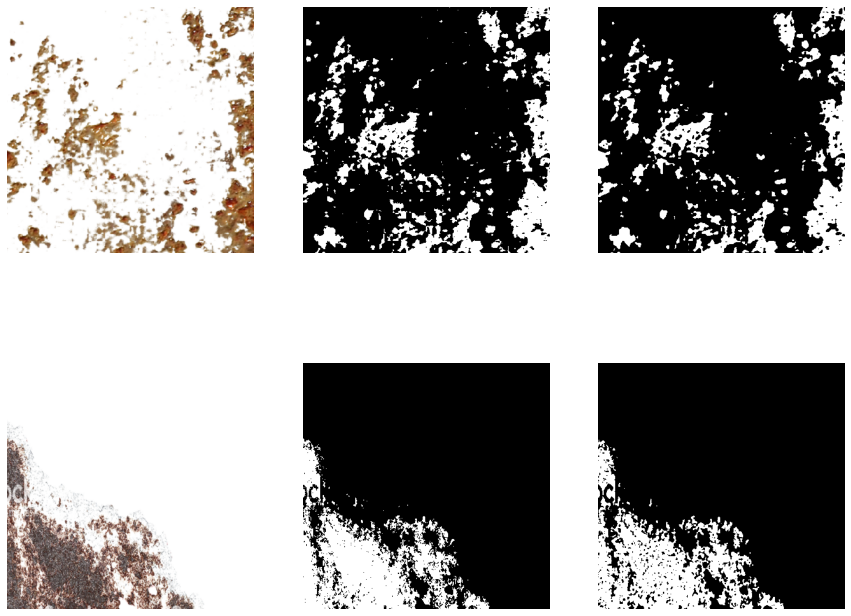

In [ ]:
inputs = F.pad(inputs,(-92,-92,-92,-92))
input_img = inputs.cpu().numpy()
gt = labels.cpu().numpy()
pred = output.data.cpu().numpy()
pred = np.argmax(pred, axis=1)
visualize(input_img, gt, pred)

#Testing


In [ ]:
test_dataset=DataLoaderSegmentationVal(folder_path="",file_path_img='image_t', file_path_mask='mask_t')
test_dataloader=data.DataLoader(test_dataset, batch_size=4, shuffle=False)
print(len(test_dataloader))

['image_t/L40.png', 'image_t/L87.png', 'image_t/L18.png', 'image_t/L85.png']
['mask_t/L40.png', 'mask_t/L87.png', 'mask_t/L18.png', 'mask_t/L85.png']
1


##Display test outputs

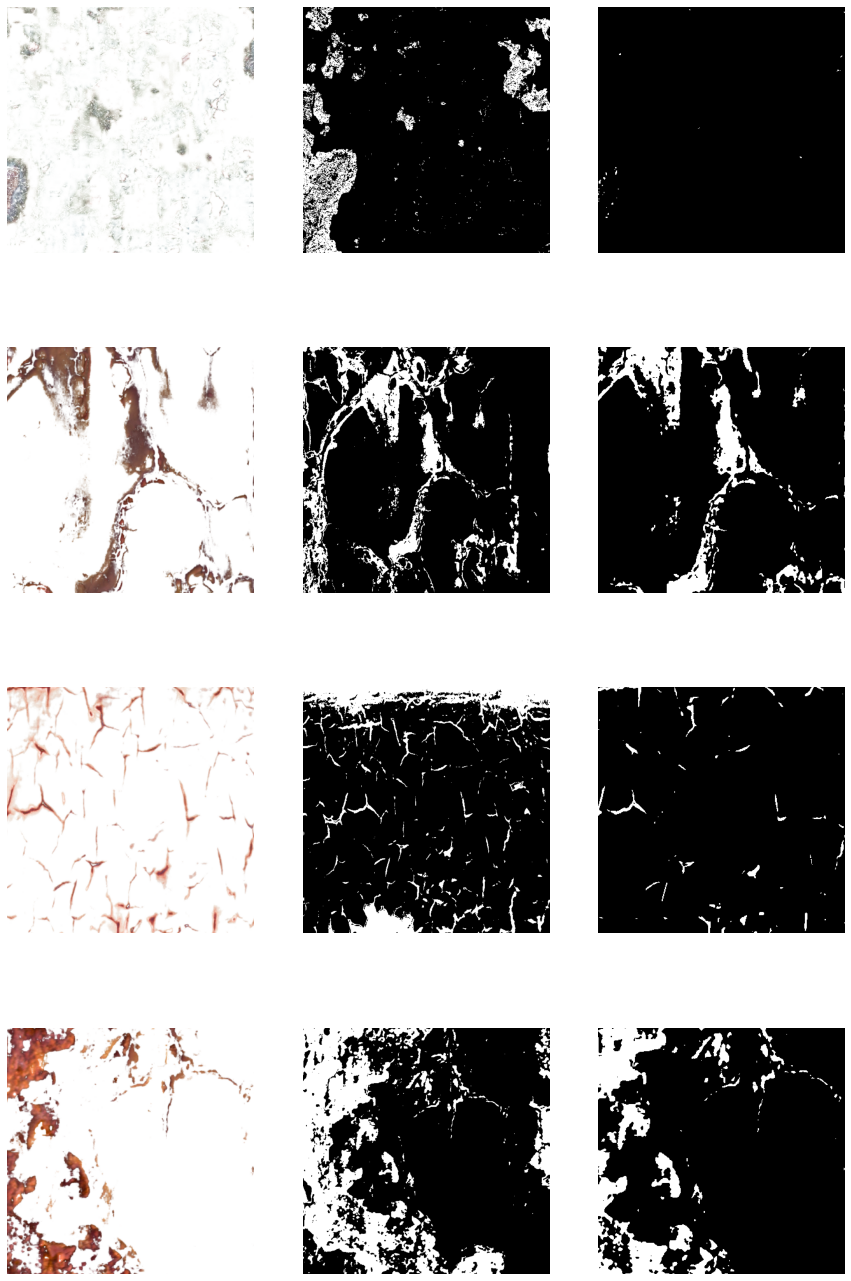

In [ ]:
for inputs, labels in test_dataloader:                
        
    inputs=inputs.cuda()
    with torch.no_grad(): # Tell torch not to calculate gradients
        output = model.forward(inputs) # Forward pass
    
    # Add batch sample into 
    inputs = F.pad(inputs,(-92,-92,-92,-92)) ##
    input_img = inputs.cpu().numpy()
    gt = labels.cpu().numpy()
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    visualize(input_img, gt, pred)

# Testing with PIL


In [ ]:
mask_list=glob.glob(os.path.join("",'mask','*.png'))
print(len(mask_list))

20


In [ ]:
def display(img,mask,alpha):
  plt.figure(figsize=(15,20))
  plt.subplot('131')
  plt.imshow(img, cmap=plt.cm.gray)
  plt.subplot('132')
  plt.imshow(mask, cmap=plt.cm.gray)
  plt.subplot('133')
  plt.imshow(alpha, cmap=plt.cm.gray)
  plt.show(img)

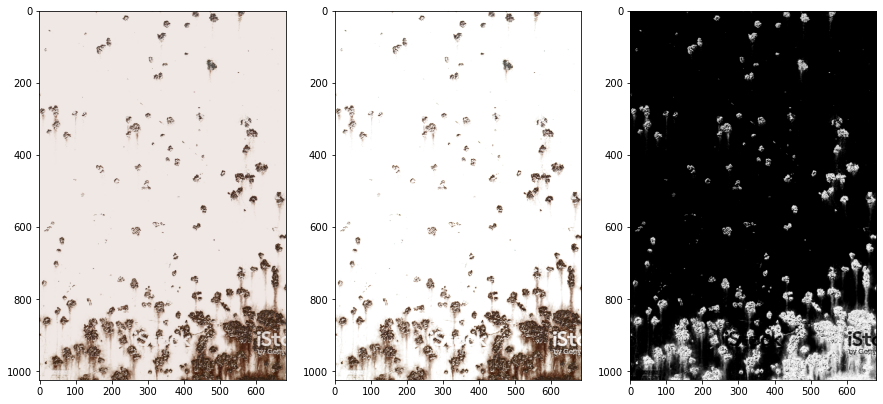

In [ ]:
img=Image.open('image/4.png','r')
mask=Image.open('mask/4.png','r')
alpha=mask.split()[-1]
display(img, mask, alpha)

In [ ]:
def Display(mask,alpha):
  plt.figure(figsize=(15,20))
  plt.subplot('131')
  plt.imshow(mask, cmap=plt.cm.gray)
  plt.subplot('132')
  plt.imshow(alpha, cmap=plt.cm.gray)
  plt.show()

#for path in mask_list:
 # mask_path=path
 # mask=Image.open(mask_path, 'r')
 # alpha=alpha_channel(mask_path)
 # alpha.save('alpha_channels/'+str(index))
 # Display(mask, alpha)

path="mask_v/"

for filename in os.listdir(path):
  print(filename)
  #mask_path=path
  mask=Image.open(os.path.join(path,filename), 'r')
  alpha=alpha_channel_add(os.path.join(path,filename))
  #alpha.save('alpha_channels/'+str(filename))
  Display(mask, alpha)



L74.png
(<PIL.Image.Image image mode=L size=1000x1000 at 0x7F65F83BAC18>, <PIL.Image.Image image mode=L size=1000x1000 at 0x7F65F83BA8D0>, <PIL.Image.Image image mode=L size=1000x1000 at 0x7F65F83BA828>, <PIL.Image.Image image mode=L size=1000x1000 at 0x7F65F83BA390>)
11.png
(<PIL.Image.Image image mode=L size=1024x689 at 0x7F65F83BA940>, <PIL.Image.Image image mode=L size=1024x689 at 0x7F65F83BA390>, <PIL.Image.Image image mode=L size=1024x689 at 0x7F65F83BAF60>, <PIL.Image.Image image mode=L size=1024x689 at 0x7F65F83BA9E8>)
6.png
(<PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA8D0>, <PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA9E8>, <PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA240>, <PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA438>)
10.png
(<PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA390>, <PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA438>, <PIL.Image.Image image mode=L size=1024x683 at 0x7F65F83BA828>, <PIL